<a href="https://colab.research.google.com/github/OmarAlsaqa/HeadPose/blob/master/HeadPose_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from PIL import Image, ImageFilter
import cv2

In [0]:
ds, info = tfds.load('the300w_lp', split='train', shuffle_files=True, as_supervised=None, with_info=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

Shuffling and writing examples to /root/tensorflow_datasets/the300w_lp/1.0.0.incompleteM5NQHH/the300w_lp-train.tfrecord



Dataset the300w_lp downloaded and prepared to /root/tensorflow_datasets/the300w_lp/1.0.0. Subsequent calls will reuse this data.


In [0]:
info.splits['train'].num_examples

61225

In [0]:
ds

<DatasetV1Adapter shapes: {color_params: (7,), exp_params: (29,), illum_params: (10,), image: (450, 450, 3), landmarks_2d: (68, 2), landmarks_3d: (68, 2), landmarks_origin: (68, 2), pose_params: (7,), roi: (4,), shape_params: (199,), tex_params: (199,)}, types: {color_params: tf.float32, exp_params: tf.float32, illum_params: tf.float32, image: tf.uint8, landmarks_2d: tf.float32, landmarks_3d: tf.float32, landmarks_origin: tf.float32, pose_params: tf.float32, roi: tf.float32, shape_params: tf.float32, tex_params: tf.float32}>

In [0]:
for i in tfds.as_numpy(ds):
  a = i['color_params']
  b = i['exp_params']
  c = i['illum_params']
  d = i['image']
  e = i['landmarks_2d']
  f = i['landmarks_3d']
  g = i['landmarks_origin']
  h = i['pose_params']
  j = i['roi']
  k = i['tex_params']
  l = i['shape_params']

In [0]:
y= (e*450).T

In [0]:
x = d

In [0]:
img = cv2.resize(x, (225,225))

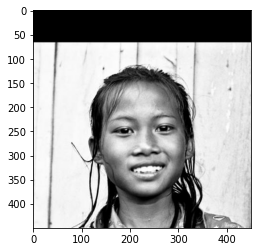

In [0]:
plt.imshow(x)

In [0]:
croped_imgs = []
cont_labels = []
bin_labels = []
for i in tfds.as_numpy(ds):
  x = i['image']
  e = i['landmarks_2d']
  h = i['pose_params']


  y= (e*450).T

  x_min = min(y[0, :])
  y_min = min(y[1, :])
  x_max = max(y[0, :])
  y_max = max(y[1, :])

  #print("x_min:{},x_max:{},y_min:{},y_max{}".format(x_min, x_max, y_min, y_max))

  Lx = abs(x_max - x_min)
  Ly = abs(y_max - y_min)
  Lmax = max(Lx, Ly) * 1.5
  center_x = x_min + Lx // 2
  center_y = y_min + Ly // 2

  x_min = center_x - Lmax // 2
  x_max = center_x + Lmax // 2
  y_min = center_y - Lmax // 2
  y_max = center_y + Lmax // 2

  if x_min < 0:
      y_max -= abs(x_min)
      x_min = 0
  if y_min < 0:
      x_max -= abs(y_min)
      y_min = 0
  if x_max > x.shape[1]:
      y_min += abs(x_max - x.shape[1])
      x_max = x.shape[1]
  if y_max > x.shape[0]:
      x_min += abs(y_max - x.shape[0])
      y_max = x.shape[0]

  #print("x_min:{},x_max:{},y_min:{},y_max{}".format(x_min, x_max, y_min, y_max))
  crop_img = x[int(y_min):int(y_max), int(x_min):int(x_max)]

  #print(crop_img.shape)
  #plt.imshow(crop_img)
  #cv2.waitKey(0)
  crop_img = np.asarray(cv2.resize(crop_img, (128, 128)))
  normed_img = (crop_img - crop_img.mean()) / crop_img.std()
  #print(normed_img)
  
  croped_imgs.append(normed_img)

  pose = h[:3]

  yaw = pose[1] * 180.0 / np.pi
  pitch = pose[0] * 180.0 / np.pi
  roll = pose[2] * 180.0 / np.pi

  cont_labels.append([yaw, pitch, roll])

  # print(cont_labels)
  # Bin values
  bins = np.array(range(-99, 99, 3))
  bin_labels.append(np.digitize([yaw, pitch, roll], bins) - 1)

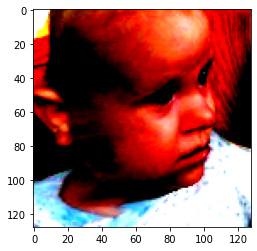

In [0]:
plt.imshow(croped_imgs[900])

In [0]:
cont_labels[900]

[-56.87611219990923, -23.916370124115915, 4.794465802042437]

In [0]:
bin_labels[900]

array([14, 25, 34])

In [0]:
def plot_pose_cube(img, yaw, pitch, roll, tdx=None, tdy=None, size=150.):
    # Input is a cv2 image
    # pose_params: (pitch, yaw, roll, tdx, tdy)
    # Where (tdx, tdy) is the translation of the face.
    # For pose we have [pitch yaw roll tdx tdy tdz scale_factor]

    p = pitch * np.pi / 180
    y = -(yaw * np.pi / 180)
    r = roll * np.pi / 180
    if tdx != None and tdy != None:
        face_x = tdx - 0.50 * size
        face_y = tdy - 0.50 * size
    else:
        height, width = img.shape[:2]
        face_x = width / 2 - 0.5 * size
        face_y = height / 2 - 0.5 * size

    x1 = size * (cos(y) * cos(r)) + face_x
    y1 = size * (cos(p) * sin(r) + cos(r) * sin(p) * sin(y)) + face_y
    x2 = size * (-cos(y) * sin(r)) + face_x
    y2 = size * (cos(p) * cos(r) - sin(p) * sin(y) * sin(r)) + face_y
    x3 = size * (sin(y)) + face_x
    y3 = size * (-cos(y) * sin(p)) + face_y

    # Draw base in red
    cv2.line(img, (int(face_x), int(face_y)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(face_x), int(face_y)), (int(x2),int(y2)),(0,0,255),3)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x1-face_x),int(y2+y1-face_y)),(0,0,255),3)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x2-face_x),int(y1+y2-face_y)),(0,0,255),3)
    # Draw pillars in blue
    cv2.line(img, (int(face_x), int(face_y)), (int(x3),int(y3)),(255,0,0),2)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x3-face_x),int(y1+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x3-face_x),int(y2+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2+x1-face_x),int(y2+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(255,0,0),2)
    # Draw top in green
    cv2.line(img, (int(x3+x1-face_x),int(y3+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x2+x3-face_x),int(y2+y3-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x1-face_x),int(y3+y1-face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x2-face_x),int(y3+y2-face_y)),(0,255,0),2)

    return img

def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [0]:
import tensorflow as tf
import os
import numpy as np
import cv2
import scipy.io as sio
#import utils

##import tensorflow.contrib.eager as tfe
#tfe.enable_eager_execution()

# np.set_printoptions(threshold=np.nan)


    
def __loss_angle(y_true, y_pred, alpha=0.5):
    # cross entropy loss
    bin_true = y_true[:,0]
    cont_true = y_true[:,1]
    cls_loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.keras.utils.to_categorical(bin_true, 66), logits=y_pred)
    # MSE loss
    pred_cont = tf.reduce_sum(tf.nn.softmax(y_pred) * idx_tensor, 1) * 3 - 99
    mse_loss = tf.losses.mean_squared_error(labels=cont_true, predictions=pred_cont)
    # Total loss
    total_loss = cls_loss + alpha * mse_loss
    return total_loss

In [0]:
input_size = 128
class_num = 3

In [0]:
inputs = tf.keras.layers.Input(shape=(input_size, input_size, 3))

feature = tf.keras.layers.Conv2D(filters=64, kernel_size=(11, 11), strides=4, padding='same', activation=tf.nn.relu)(inputs)
feature = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2)(feature)
feature = tf.keras.layers.Conv2D(filters=192, kernel_size=(5, 5), padding='same', activation=tf.nn.relu)(feature)
feature = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2)(feature)
feature = tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(feature)
feature = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(feature)
feature = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(feature)
feature = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2)(feature)
feature = tf.keras.layers.Flatten()(feature)
feature = tf.keras.layers.Dropout(0.5)(feature)
feature = tf.keras.layers.Dense(units=4096, activation=tf.nn.relu)(feature)

fc_yaw = tf.keras.layers.Dense(name='yaw', units=class_num)(feature)
fc_pitch = tf.keras.layers.Dense(name='pitch', units=class_num)(feature)
fc_roll = tf.keras.layers.Dense(name='roll', units=class_num)(feature)

model = tf.keras.Model(inputs=inputs, outputs=[fc_yaw, fc_pitch, fc_roll])

losses = {
    'yaw':__loss_angle,
    'pitch':__loss_angle,
    'roll':__loss_angle,
}

model.compile(optimizer='adam',
                loss=losses)


In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 32, 32, 64)   23296       input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 15, 15, 64)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 15, 15, 192)  307392      max_pooling2d_6[0][0]            
____________________________________________________________________________________________

In [0]:
model.fit(x_train, y_train, epochs=25, steps_per_epoch= info.splits['train'].num_examples // 64, max_queue_size=10, workers=1, verbose=1, validation_split = 0.2)

#model.save(model_path)